# Data-Driven real-estate investment risk model
## Model Training and results
In this file I will,
1. Input the cleaned up datatable
2. Train the model on the factors and change in quarterly return
3. Estimate the weights and test the prediction performance on error metric.

In addition to it, I also made prediction on change in quarterly returns using previous weights and compared the performance error with data-driven model predictions.

**Before running this code I put in an option to either display the results or display the results and save them as well.**
Set the variable below to 'Yes' to save results, otherwise set it to 'No' to just see the results.

In [1]:
write_to_file='Yes' # 'Yes'

Importing neccessary libraries

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython import get_ipython
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

Although it is not advisable but to keep this notebook clean and short, supress warnings. Comment this when you want to see warnings

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Importing Data

First I import the cleaned datatable containing quarterly data on the factors and change quarterly returns for different markets.

In [4]:
Data=pd.read_csv(r'Input_data_market_risk_model.csv')

First few rows of this datatable,

In [5]:
Data.head()

,Under Constr % of Inventory,Date,Market Occupancy,Total Employed,Unemployment Rate,Housing Demand Quotient,state,msa code,Change In Return,Population Estimate,Market
0,0.077813,2018-10-01,0.941469,1736200.0,3.8,44.477334,WA,42644,-0.207388,3939363.0,Seattle
1,0.075314,2018-07-01,0.944947,1724400.0,4.0,40.722087,WA,42644,0.340640,3939363.0,Seattle
2,0.077475,2018-04-01,0.945757,1716400.0,3.7,42.028420,WA,42644,0.628392,3939363.0,Seattle
3,0.074218,2018-01-01,0.943161,1710900.0,4.6,50.819533,WA,42644,-1.976761,3939363.0,Seattle
4,0.073655,2017-10-01,0.940336,1694600.0,4.0,43.767138,WA,42644,-0.485984,3925639.5,Seattle


To see how good the new weights are, I also made prediction using weights that are currently being used to estimate risk-score. Here is the table of these weights, 

Note: Weights are re-scaled to give a out of 100 score to each factor.

In [6]:
Current_Weights=pd.read_excel(r'Data/Current_Weights.xlsx')
Current_Weights.set_index('Factor',inplace=True)
Current_Weights

,Weight,re-scaled weights
Factor,,
Market Occupancy,4,6
Housing Demand Quotient,15,21
Under Constr % of Inventory,15,21
Total Employed,30,43
Unemployment Rate,0,0
Population Estimate,5,7


I am looking at the markets of 14 Metropolitan areas across USA. These areas are identified by their MSA (Metropolitan Statistical Area) codes.

Importing msa codes data.  

In [7]:
MSA_codes=pd.read_excel(r'Data/MSA_codes.xlsx')
MSA_codes

,msa code,Metropolitan area,Market,State
0,12060,Atlanta‐Sandy Springs‐Roswell,Atlanta,GA
1,14454,Boston,Boston,MA
2,16740,Charlotte‐Concord‐Gastonia,Charlotte,NC
3,16974,Chicago‐Naperville‐Arlington Heights,Chicago,IL
4,19124,Dallas-Plano-Irving,Dallas,TX
5,19740,Denver-Aurora-Lakewood,Denver,CO
6,26420,Houston-The Wood Lands-Sugar Land,Houston,TX
7,28140,Kansas City,Kansas_City,KS
8,31084,Los Angeles-Long Beach-Glendale,Los_Angeles,CA
9,37964,Philadelphia,Philadelphia,PA


## Feature Scaling
Before I feed the data into the model I need to scale all the different columns to same range. Why we do this? If we kept the factors data in their current form and then train the model, it will give us weights heavily biased on the scale of factors data. I perform **Max-Min feature scaling** with range as [0,1] so that the smallest datapoint for each factor is converted to zero and highest datapoint converts to 1. Here is the formula to perform this transformation.
\begin{equation*}
X_{new} = \frac{X_{old} - min(X_{old})}{max(X_{old}) - min(X_{old})}
\end{equation*}

In [8]:
def feature_scaling(Data):    
    Scaling=MinMaxScaler(feature_range=(0,1))
    return Scaling.fit_transform(np.float64(Data))

## Error Metric: Weighted mean absolute percent error (WMAPE)
To judge the prediction performance of a model I used a metric called as weighted mean absolute percent error. This metric gives a estimate of how off I am to the actual value. This is the formula.
\begin{equation*}
WMAPE = \sum_{i=0}^{N}\frac{|y_{actual}^i-y_{predicted}^i|}{\sum_{i=0}^{N}|y_{actual}^i|}
\end{equation*}

In [9]:
def WMAPE(y_true,y_pred):
    return 100*np.sum(abs(y_true - y_pred))/np.sum(abs(y_true))

## Model training
My strategy to estimate weights is simple, **take data, train the model, get the weights.** But working with small size data-set, the weights I estimate will be biased towards the training data. To go around that issue I performed this task **[take data, train the model, get the weights]** many times and each time with randomly selected training and testing data. What I get at the end are lists of weights from each training run. As the final result I calculate the 1st-3rd quartile and median of these lists. Hopefully as more data is added this step is not neccessary, but currently I am performing 1000 such training-testing runs.

In [10]:
Number_of_runs=1000

I create a function that takes in data for the market and trains 1000 models. The function will return a datatable containing lists weights associated with each factor.

In [11]:
def ML_Model(Data,ns=1):
    Factors=list(Data.columns.drop(['Date','msa code','state','Market','Change In Return']))# create a list of factors
    # feature scale input datatable (factors)
    X=feature_scaling(Data[Factors])
    # feature scale output datatable (Change in quarterly returns)
    Y=feature_scaling(Data['Change In Return'].values.reshape(-1,1))
    # randomly create train-test split 'ns' times
    ss = ShuffleSplit(n_splits=ns, test_size=0.33,random_state=0)
    wmape=[]
    wmape_check=[]
    weights=[]
    for train, test in ss.split(X): # loop over training runs
        # split into training and testing data
        X_train,X_test,y_train,y_test=X[train],X[test],Y[train],Y[test]
        #Call linear regression model with intercept
        model=LinearRegression(fit_intercept=True)
        # fit the model on trainning data
        model_fit=model.fit(X_train,y_train)
        # make prediction on testing data using the fitted model
        y_pred=model_fit.predict(X_test)
        y_pred=y_pred.reshape(-1,1)
        # make prediction on testing data using old weights
        y_check=np.dot(X_test,Current_Weights['re-scaled weights']/100)
        y_check=y_check.reshape(-1,1)
        # get coefficients from the fitted linear model 
        Coeffs=model_fit.coef_.flatten()
        # rescale coefficients to [0,1] range to make weights out of 100 
        Coeffs=np.absolute(Coeffs)/np.sum(np.absolute(Coeffs))
        # wmape prediction error for fitted model
        wmape.append(WMAPE(y_test,y_pred))
        # wmape prediction error for old weights model
        wmape_check.append(WMAPE(y_test,y_check))
        # estimated weights 
        weights.append(Coeffs)
    # storing all results in a datatable
    Results=pd.DataFrame(data=np.round(np.multiply(np.absolute(weights),100)))
    Results.columns=Factors
    Results['WMAPE']=wmape
    Results['WMAPE (old weights)']=wmape_check
    return Results

## Results
I created a table with rows as the different factors and error and columns as the 1st-quartile, median and 3rd-quartile which are estimated from list of weights generated from 1000 trainned models.

In [12]:
def results_Quantile(Results):
    # creating a datatable to save quartiles
    Quantile_Df=pd.concat([Results.quantile(q=0.25,axis=0).transpose(), # 1st quartile (lower limit)
                           Results.quantile(q=0.5,axis=0).transpose(), # 2nd quartile median
                           Results.quantile(q=0.75,axis=0).transpose()],axis=1) # 3rd quartile (upper limit)
    Quantile_Df.columns=['1st-quartile','median','3rd-quartile']
    return round(Quantile_Df,2)

In [13]:
def create_figure(df,market):
    # creating a boxplot
    plt.boxplot(df.drop(['WMAPE','WMAPE (old weights)'],axis=1).transpose(), # including only weights results
                labels=df.drop(['WMAPE','WMAPE (old weights)'],axis=1).columns,# factor labels
                showfliers=False, # not showing outlier on boxplot
                showcaps=False,whis=0,# not showing whiskers
               medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick'), # styling of median line
               boxprops = dict(linestyle='-', linewidth=3, color='darkgoldenrod'))# styling of quartile range box
    # figure title
    plt.title('Market Risk model, Market: %s\n Median and 1st-3rd Quartile'%market,fontsize=14)
    # figure labels
    plt.ylabel('Estimated Weights',fontsize=14)
    plt.xlabel('Factors',fontsize=14)
    # figure ticks
    plt.xticks(fontsize=12, rotation=90)
    plt.yticks(fontsize=12)

I present the Quartiles of weights in a table and also in boxplot, first for 'All US' data combined from all 14 markets.


                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory          3.00    6.00          11.0
Market Occupancy                     3.00    5.00          10.0
Total Employed                      11.00   19.00          26.0
Unemployment Rate                   21.00   28.00          36.0
Housing Demand Quotient             11.00   20.00          28.0
Population Estimate                 10.00   18.00          25.0
WMAPE                                7.87    8.17           8.5
WMAPE (old weights)                 32.75   33.26          33.8


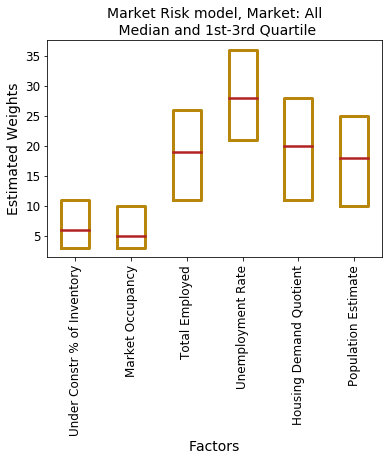

In [14]:
# run the model on 'All' market data to get weights
Market_Results=ML_Model(Data,Number_of_runs)
# get quartile of weights trainned on 'All' market data
Market_Quantile=results_Quantile(Market_Results)
# estimate the improvement in error prediction from old weights model to data-driven model
Improvement=pd.Series(index=['All'],data=Market_Quantile.loc['WMAPE','median']/Market_Quantile.loc['WMAPE (old weights)','median'])
# create the results figure
create_figure(Market_Results,market='All')
if write_to_file=='Yes': # do you want to save results to files? 'Yes' or 'No'
    output_name='Results/Tables/Weights_All_US_Market.csv' # filepath for quartiles of weights table
    Market_Quantile.to_csv(output_name) # save to file
    plt.savefig('Results/Figures/All.png',bbox_inches = "tight") # save figure to file
print(round(Market_Quantile,2)) # display quartiles of weights table
plt.show()

Quartiles of weights in a table and also in boxplot for all 14 markets individually.

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory          7.00   12.00         21.00
Market Occupancy                     3.00    5.00         10.00
Total Employed                      24.00   30.00         32.00
Unemployment Rate                   12.00   17.00         21.00
Housing Demand Quotient              2.00    5.00          9.00
Population Estimate                 25.00   31.00         34.00
WMAPE                               17.91   19.94         22.22
WMAPE (old weights)                 40.92   42.92         45.32


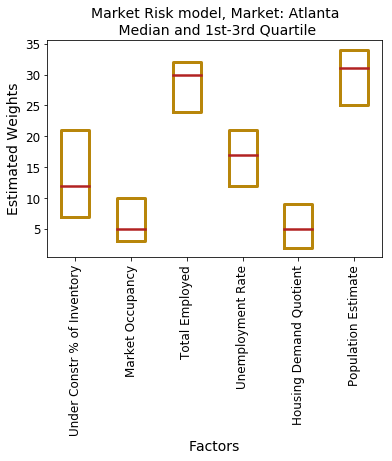

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory          5.00    9.00         18.00
Market Occupancy                     5.00    9.00         15.00
Total Employed                      16.00   26.00         32.00
Unemployment Rate                   11.00   18.00         23.00
Housing Demand Quotient              8.00   15.00         27.00
Population Estimate                 12.00   19.00         25.00
WMAPE                               22.81   26.09         29.79
WMAPE (old weights)                 30.25   32.96         36.12


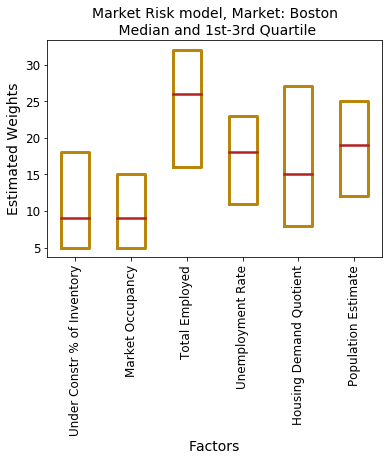

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory          5.00   10.00         15.00
Market Occupancy                     5.00   12.00         19.00
Total Employed                      20.00   29.00         35.00
Unemployment Rate                   11.00   20.00         25.00
Housing Demand Quotient              4.00    8.00         14.00
Population Estimate                 15.00   23.00         27.00
WMAPE                               13.58   15.33         17.16
WMAPE (old weights)                 44.71   46.59         48.57


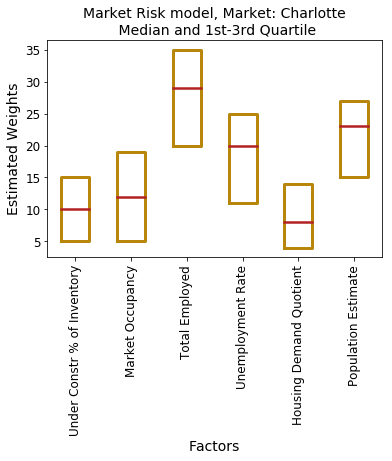

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory         19.00   26.00         30.00
Market Occupancy                     4.00    8.00         14.00
Total Employed                      20.00   36.00         42.00
Unemployment Rate                    8.00   14.00         20.00
Housing Demand Quotient              3.00    6.00         13.00
Population Estimate                  6.00   11.00         16.00
WMAPE                               16.46   18.48         20.92
WMAPE (old weights)                 32.36   34.67         36.69


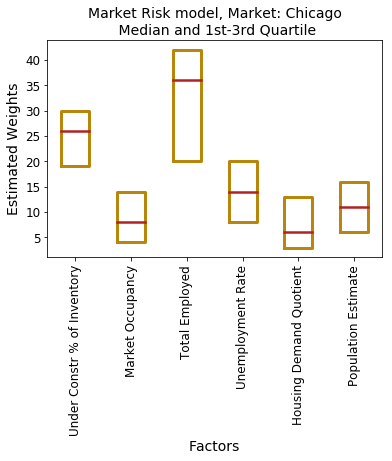

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory         23.00   32.00         39.00
Market Occupancy                     3.00    6.00          9.00
Total Employed                       9.00   17.00         28.00
Unemployment Rate                   11.00   19.00         23.00
Housing Demand Quotient              8.00   13.00         17.00
Population Estimate                  8.75   16.00         21.00
WMAPE                               18.96   21.21         23.60
WMAPE (old weights)                 36.86   39.10         41.28


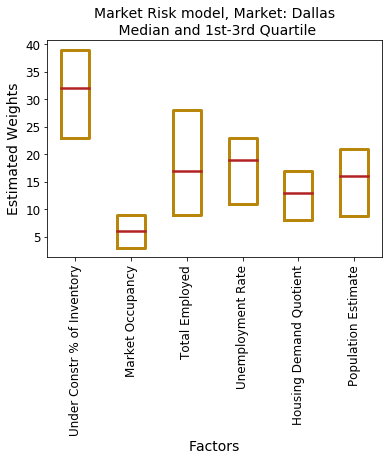

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory          7.00   11.00         16.00
Market Occupancy                    16.00   21.00         25.00
Total Employed                       9.00   16.00         24.00
Unemployment Rate                    4.00    9.00         14.00
Housing Demand Quotient             23.00   29.00         35.00
Population Estimate                  6.00   13.00         18.00
WMAPE                               17.21   19.65         22.15
WMAPE (old weights)                 38.57   40.77         43.22


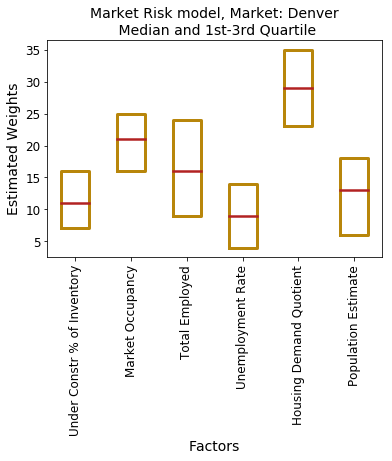

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory          2.00    5.00           9.0
Market Occupancy                     3.00    5.00           8.0
Total Employed                      35.00   40.00          43.0
Unemployment Rate                    3.00    5.00           7.0
Housing Demand Quotient              2.00    5.00          10.0
Population Estimate                 33.00   39.00          42.0
WMAPE                               24.65   27.43          30.4
WMAPE (old weights)                 34.26   37.09          39.8


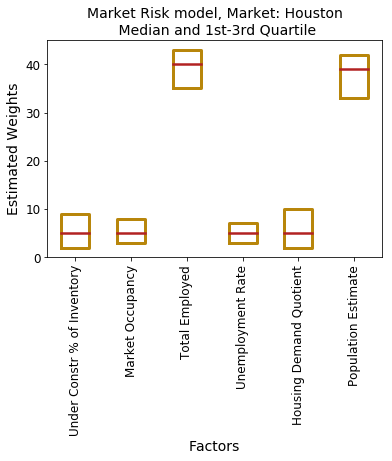

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory          8.00   14.00         20.00
Market Occupancy                     3.00    6.00         11.00
Total Employed                      17.00   27.00         35.00
Unemployment Rate                    7.00   16.00         25.00
Housing Demand Quotient              5.00   11.00         20.00
Population Estimate                 15.00   23.00         28.00
WMAPE                               31.59   35.28         39.14
WMAPE (old weights)                 37.15   40.88         45.63


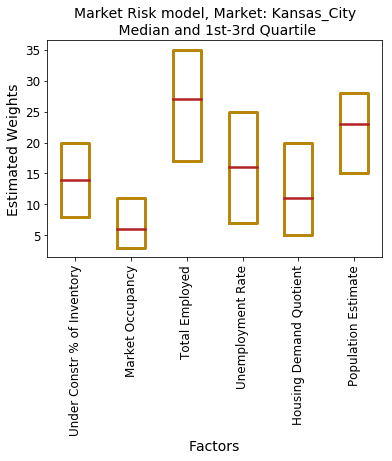

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory         27.75   34.00         38.00
Market Occupancy                     6.00   10.00         14.00
Total Employed                      18.00   27.00         36.00
Unemployment Rate                    3.00    7.00         12.00
Housing Demand Quotient              2.00    5.00          9.00
Population Estimate                 10.00   17.00         24.00
WMAPE                               19.91   22.15         24.49
WMAPE (old weights)                 34.24   36.67         38.95


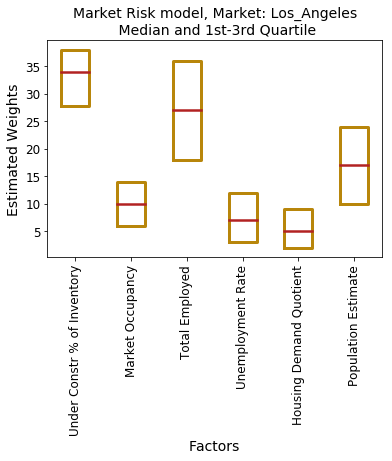

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory          5.00   10.00         17.00
Market Occupancy                    12.00   17.00         22.00
Total Employed                      14.00   20.00         24.00
Unemployment Rate                   16.00   21.00         24.00
Housing Demand Quotient              4.00    7.00         12.00
Population Estimate                 17.00   24.00         28.00
WMAPE                               31.31   35.46         40.32
WMAPE (old weights)                 26.96   31.78         36.43


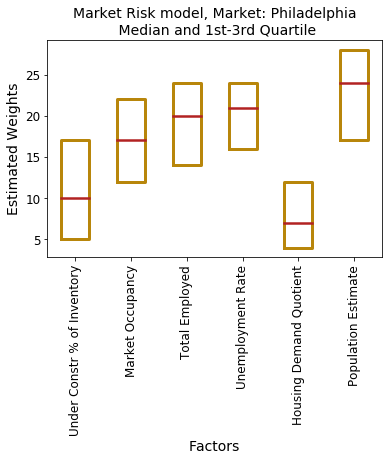

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory         14.00   18.00         21.00
Market Occupancy                    11.00   15.00         18.00
Total Employed                      10.00   18.00         25.00
Unemployment Rate                    4.00    9.00         15.00
Housing Demand Quotient             17.00   24.00         31.00
Population Estimate                  9.00   17.00         24.00
WMAPE                               18.71   21.16         24.12
WMAPE (old weights)                 28.55   31.16         34.13


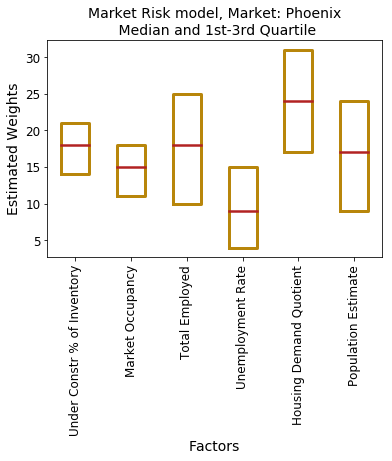

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory          5.00   11.00         20.00
Market Occupancy                     3.00    8.00         14.00
Total Employed                      17.00   27.00         33.00
Unemployment Rate                   11.00   19.00         25.00
Housing Demand Quotient              7.00   13.00         18.00
Population Estimate                 15.00   22.00         26.00
WMAPE                               14.66   16.99         19.33
WMAPE (old weights)                 31.54   33.87         36.17


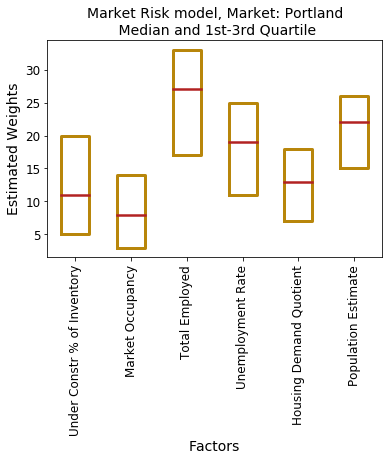

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory          4.00    7.00         10.00
Market Occupancy                     4.00    9.00         19.00
Total Employed                      18.00   27.00         32.00
Unemployment Rate                   13.00   18.00         22.00
Housing Demand Quotient             12.00   16.00         20.00
Population Estimate                 16.00   23.00         26.00
WMAPE                               13.49   16.61         19.82
WMAPE (old weights)                 29.14   31.41         33.87


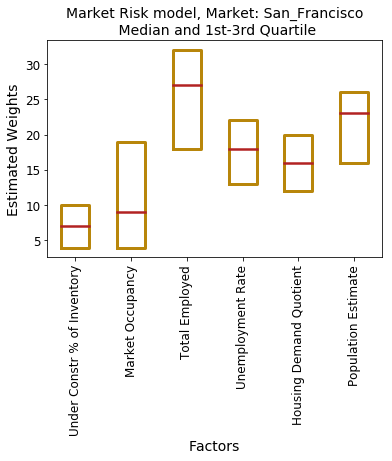

                             1st-quartile  median  3rd-quartile
Under Constr % of Inventory          3.00    5.00          9.00
Market Occupancy                     5.00   10.00         16.00
Total Employed                      22.00   29.00         33.00
Unemployment Rate                   11.00   20.00         26.00
Housing Demand Quotient              9.00   17.00         23.00
Population Estimate                 17.00   21.00         24.00
WMAPE                               16.94   19.55         22.05
WMAPE (old weights)                 29.38   32.05         34.72


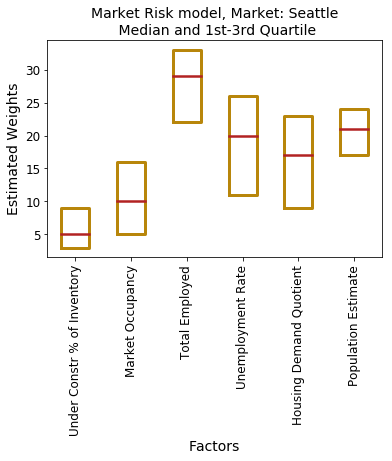

In [15]:
for city in MSA_codes.Market: # run loop over different market cities
    # select data for a chosen market
    Data_cut=Data[(Data.Market==city)]
    # run the model on a particulat market data to get weights
    Market_Results=ML_Model(Data_cut,Number_of_runs)
    # estimate quartile of the weights
    Market_Quantile=results_Quantile(Market_Results)
    # estimate the improvement in error prediction from old weights model to data-driven model
    Improvement[city]=Market_Quantile.loc['WMAPE','median']/Market_Quantile.loc['WMAPE (old weights)','median']
    # create the results figure
    create_figure(Market_Results,market=city)
    if write_to_file=='Yes': # do you want to save results to files? 'Yes' or 'No'
        output_name='Results/Tables/Weights_'+city+'.csv' # filepath for quartiles of weights table
        Market_Quantile.to_csv(output_name) # save to file
        plt.savefig('Results/Figures/%s.png'%city,bbox_inches = "tight") # save figure to file
    print(round(Market_Quantile,2)) # display quartiles of weights table
    plt.show()

## Improvement in previous model

Now the most important part of this project, how well are we doing with the new weights. Here I compared the error in prediction from the old model to new data-driven model.

\begin{equation*}
\% Reduction=\frac{Error \: (old \: model) - Error \: (new \: model)}{Error \: (old \: model)}*100
\end{equation*}

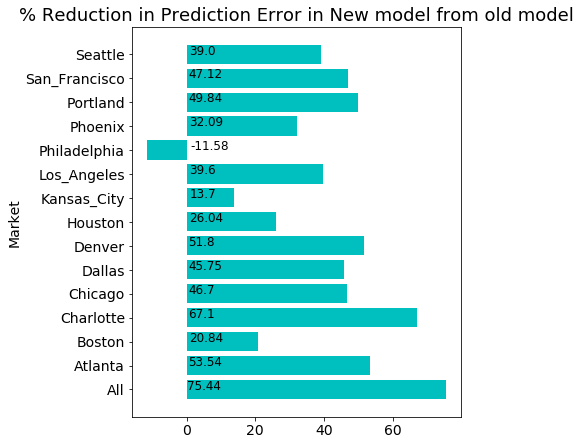

In [16]:
plt.figure(figsize=(6,6))
# display bar plot to show prediction error improvement
plt.barh(Improvement.index,round((1-Improvement)*100,2),color='c')
# display numeric value of improvement on the plot
for key,value in zip(Improvement.index,Improvement):
    plt.text(value,key,round((1-value)*100,2),fontsize=12,color='k')
# set the layout, axes and labels
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Market',fontsize=14)
plt.title('% Reduction in Prediction Error in New model from old model',fontsize=18)
plt.show()

Done.